# Transfer learning and fine-tuning with Keras (Xception model)

This notebook is loosely based on [Keras example](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html). This is a fine-grain, multi-class classifier problem, with few-shot learning (we have less than 10 training samples for a lot of our classes). 

To achieve this, we'll leverage the pre-built Xception model for the earlier layers, and stack a smaller model on top of this.  

Here are the key steps:
1. First, we create the Xception model (we'll call this the 'base model') with pre-built weights; the top layer is omitted 
2. Next, we generate the bottlenck features and accompanying training / validation labels (this will be useful when training the model in steps 5 and y)
3. Next, we'll stack a much smaller model on top of the 'base' model (the smaller model will be referred to as 'top model')
4. To establish a baseline, we'll test this untrained model (since it has random weights, this will have very poor performance)
5. Now, we will train the 'top model' alone with relatively large learning rate using the bottleneck features from step 2 (the best performing weights are automatically saved) 
6. We will retest the entire model with the trained 'top model' weights
7. Now, we will set up training data to flow from directory with real-time augmentation 
8. With this augmented training data, we will fine-tune the top layers of the 'base model' and all the layers in the 'top model' (the best performing weights are automatically saved) 
9. Finally, we'll retest the entire model with the fine-tuned weights

First, take care of imports and initial setup.

In [1]:
import numpy as np
import pandas as pd
from os import listdir, makedirs, walk
from os.path import isdir, isfile, join, exists, expanduser
from tqdm import tqdm_notebook
import datetime
from itertools import compress

from keras.models import Sequential, Model
from keras.optimizers import Adam, SGD, RMSprop
from keras.layers import Dropout, Flatten, Dense, Input, GlobalAveragePooling2D, BatchNormalization, deserialize
from keras.utils import to_categorical
from keras.applications import xception
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array
from keras.applications.xception import preprocess_input
from keras.callbacks import *

from keras.preprocessing import image
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
%matplotlib inline

/home/paperspace/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Xception needs images of size 299 x 299 
INPUT_SIZE = 299
BATCH_SIZE = 16

train_folder      = 'data/train/'
valid_folder      = 'data/validation/'
test_folder       = 'imgs/test'
weights_folder    = 'models/'

bottleneck_features_train_npy = 'bottleneck_features_train.npy'
bottleneck_features_valid_npy = 'bottleneck_features_valid.npy'
bottleneck_labels_train_npy = 'bottleneck_labels_train.npy'
bottleneck_labels_valid_npy = 'bottleneck_labels_valid.npy'

top_model_epochs = 50
complete_model_epochs = 50

# Number of augmented images to generate for each real image
augmented_images_multiply_factor = 3

# Create weights folder to save model weights
if not exists(weights_folder):
    makedirs(weights_folder)
    
ext = '.jpg'
classes = [fldr for fldr in listdir(train_folder) if isdir(join(train_folder, fldr))]
num_classes = len(classes)
train_samples = sum([len(files) for r, d, files in walk(train_folder)])
valid_samples = sum([len(files) for r, d, files in walk(valid_folder)])
test_samples = sum([len(files) for r, d, files in walk(test_folder)])

print ("Classes: {}, Training samples: {}, Validation samples: {}, Test samples: {}".format(num_classes, train_samples, valid_samples, test_samples))

Classes: 33, Training samples: 1725, Validation samples: 418, Test samples: 32


A quick view of the underlying data (images chosen at random)

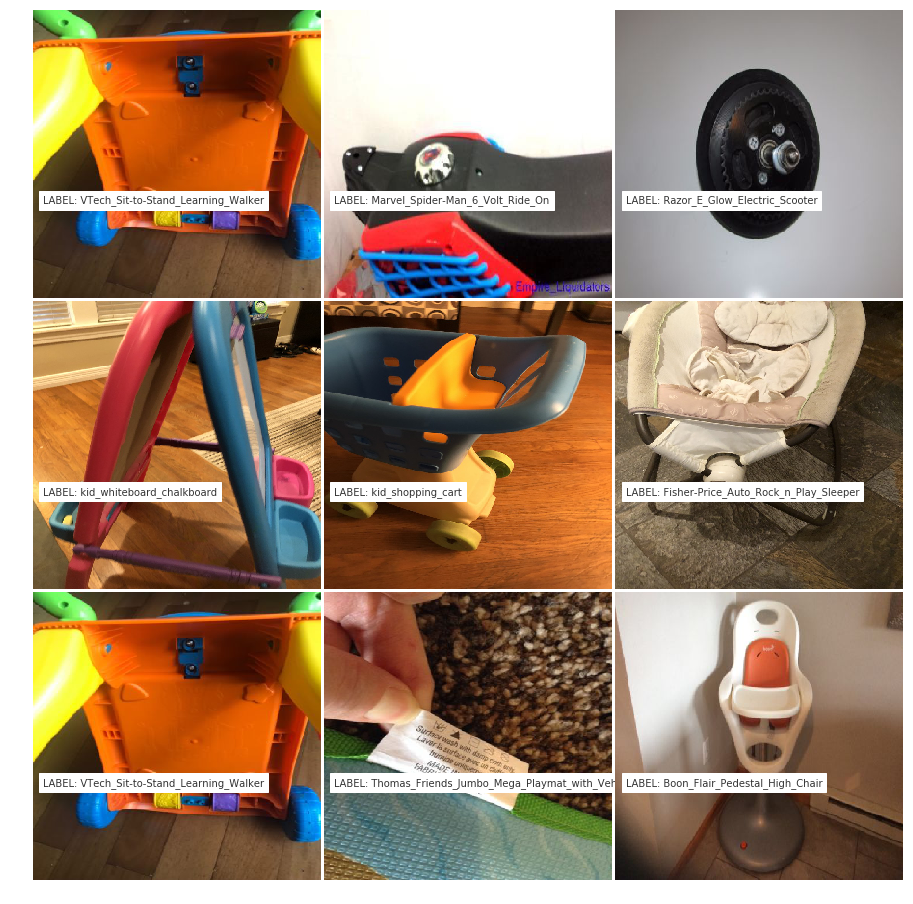

In [3]:
fig = plt.figure(1, figsize=(16, 16))
grid = ImageGrid(fig, 111, nrows_ncols=(3, 3), axes_pad=0.05)

for i, cls in enumerate(np.random.choice(classes, 9)):
    ax = grid[i]
    img_file = np.random.choice(listdir(join(train_folder, cls)))
    img = image.load_img(join(train_folder, cls, img_file), target_size=(INPUT_SIZE,INPUT_SIZE))
    img = image.img_to_array(img)
    ax.imshow(img / 255.)
    ax.text(10, 200, 'LABEL: %s' % cls, color='k', backgroundcolor='w', alpha=0.8)
    ax.axis('off')
plt.show()

## 1. Create 'base model' without top layer and Imagenet weights

In [4]:
base_model = xception.Xception(weights='imagenet', include_top=False, input_tensor=Input(shape=(INPUT_SIZE,INPUT_SIZE,3)))

## 2. Generate bottleneck features & labels

In [5]:
if not exists(bottleneck_features_train_npy):
    # Set up data generator for bottleneck features - only need preprocessing (no augmentation)
    datagen = ImageDataGenerator(rescale=1. / 255)

    # Generate bottleneck features for training data, and accompanying labels
    generator = datagen.flow_from_directory(
        train_folder,
        target_size=(INPUT_SIZE, INPUT_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='sparse',
        shuffle=False)

    bottleneck_features_train = base_model.predict_generator(generator, verbose = 1)
    np.save(bottleneck_features_train_npy, bottleneck_features_train)

    bottleneck_labels_train = to_categorical(generator.classes, num_classes=num_classes)
    np.save(bottleneck_labels_train_npy, bottleneck_labels_train)
    
else:
    bottleneck_features_train = np.load(bottleneck_features_train_npy)
    bottleneck_labels_train = np.load(bottleneck_labels_train_npy)

Found 1725 images belonging to 33 classes.
108/108 [==============================] - 22s 200ms/step


In [6]:
if not exists(bottleneck_features_valid_npy):
    # Generate bottleneck features for validation data, and accompanying labels
    generator = datagen.flow_from_directory(
        valid_folder,
        target_size=(INPUT_SIZE, INPUT_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='sparse',
        shuffle=False)

    bottleneck_features_valid = base_model.predict_generator(generator, verbose = 1)
    np.save(bottleneck_features_valid_npy, bottleneck_features_valid)

    bottleneck_labels_valid = to_categorical(generator.classes, num_classes=num_classes)
    np.save(bottleneck_labels_valid_npy, bottleneck_labels_valid)

else:
    bottleneck_features_valid = np.load(bottleneck_features_valid_npy)
    bottleneck_labels_valid = np.load(bottleneck_labels_valid_npy)    

Found 418 images belonging to 33 classes.
27/27 [==============================] - 5s 182ms/step


## 3. Create smaller 'top' model and stack on top of 'base' model

In [7]:
# Based on https://www.depends-on-the-definition.com/transfer-learning-for-dog-breed-identification/

top_model = Sequential()
top_model.add(BatchNormalization(input_shape=bottleneck_features_train.shape[1:]))
top_model.add(GlobalAveragePooling2D())
top_model.add(Dropout(0.5))
top_model.add(Dense(1024, activation='relu', kernel_initializer='random_uniform',
                bias_initializer='zeros'))
top_model.add(Dropout(0.5))
top_model.add(Dense(num_classes, kernel_initializer='random_uniform',
                bias_initializer='zeros', activation='softmax'))

top_model.compile(optimizer=SGD(nesterov=True),
              loss='categorical_crossentropy', metrics=['accuracy'])

In [8]:
# Stack top_model on top
model = Model(inputs=base_model.input, outputs=top_model(base_model.output))

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

## 4. Establish baseline accuracy with untrained model (labeled validation images)

In [9]:
valid_datagen = ImageDataGenerator(rescale=1. / 255)
valid_generator = valid_datagen.flow_from_directory(directory=valid_folder,
                                                    target_size=(INPUT_SIZE,INPUT_SIZE),
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='categorical',
                                                    shuffle=False)

Found 418 images belonging to 33 classes.


In [10]:
generator = valid_generator
ypred = model.predict_generator(generator, verbose=1)

27/27 [==============================] - 6s 210ms/step


In [11]:
img_list = generator.filenames
df = pd.DataFrame.from_dict(generator.class_indices, orient='index')
class_list = df.sort_values(by=0).index.tolist()

In [12]:
true_classes = generator.classes
pred1_classes = np.argsort(ypred, axis=1)[:,-1] # or np.argmax(ypred, axis=1)
pred2_classes = np.argsort(ypred, axis=1)[:,-2]
pred3_classes = np.argsort(ypred, axis=1)[:,-3]
top1_error_idx = (true_classes != pred1_classes)
top3_error_idx = (true_classes != pred1_classes) & (true_classes != pred2_classes) & (true_classes != pred3_classes)

print ("Of {} images tested, top1 accuracy: {:.2f}% ({} wrong) and top3 accuracy: {:.2f}% ({} wrong)".format(
        len(img_list),
        (1-np.sum(top1_error_idx)/len(img_list))*100, np.sum(top1_error_idx),
        (1-np.sum(top3_error_idx)/len(img_list))*100, np.sum(top3_error_idx)))

Of 418 images tested, top1 accuracy: 4.07% (401 wrong) and top3 accuracy: 10.77% (373 wrong)


**Note: Running the cell below can take a long time because of the large number of errors with untrained model**

In [ ]:
error_idx = top3_error_idx

for img_path, cat, pred1, pred2, pred3 in zip(list(compress(img_list, error_idx)),
                                              [class_list[int(b)] for b in true_classes[error_idx]],
                                              [class_list[int(b)] for b in pred1_classes[error_idx]],
                                              [class_list[int(b)] for b in pred2_classes[error_idx]],
                                              [class_list[int(b)] for b in pred3_classes[error_idx]]):
    fig, ax = plt.subplots(figsize=(5,5))
    img = image.load_img(join(valid_folder, img_path), target_size=(INPUT_SIZE,INPUT_SIZE))
    img = image.img_to_array(img)
    ax.imshow(img / 255.)
    ax.text(10, 250, 'P1: %s' % pred1, color='w', backgroundcolor='r', alpha=0.8)
    ax.text(10, 270, 'P2: %s' % pred2, color='w', backgroundcolor='r', alpha=0.8)
    ax.text(10, 290, 'P3: %s' % pred3, color='w', backgroundcolor='r', alpha=0.8)
    ax.text(10, 310, 'LABEL: %s' % cat, color='k', backgroundcolor='g', alpha=0.8)
    ax.axis('off')
    plt.show()       

## 5. Train 'top model' with bottleneck features

In [13]:
# From https://github.com/bckenstler/CLR for Cyclical Learning Rate
class CyclicLR(Callback):
    """This callback implements a cyclical learning rate policy (CLR).
    The method cycles the learning rate between two boundaries with
    some constant frequency, as detailed in this paper (https://arxiv.org/abs/1506.01186).
    The amplitude of the cycle can be scaled on a per-iteration or 
    per-cycle basis.
    This class has three built-in policies, as put forth in the paper.
    "triangular":
        A basic triangular cycle w/ no amplitude scaling.
    "triangular2":
        A basic triangular cycle that scales initial amplitude by half each cycle.
    "exp_range":
        A cycle that scales initial amplitude by gamma**(cycle iterations) at each 
        cycle iteration.
    For more detail, please see paper.
    
    # Example
        ```python
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., mode='triangular')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```
    
    Class also supports custom scaling functions:
        ```python
            clr_fn = lambda x: 0.5*(1+np.sin(x*np.pi/2.))
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., scale_fn=clr_fn,
                                scale_mode='cycle')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```    
    # Arguments
        base_lr: initial learning rate which is the
            lower boundary in the cycle.
        max_lr: upper boundary in the cycle. Functionally,
            it defines the cycle amplitude (max_lr - base_lr).
            The lr at any cycle is the sum of base_lr
            and some scaling of the amplitude; therefore 
            max_lr may not actually be reached depending on
            scaling function.
        step_size: number of training iterations per
            half cycle. Authors suggest setting step_size
            2-8 x training iterations in epoch.
        mode: one of {triangular, triangular2, exp_range}.
            Default 'triangular'.
            Values correspond to policies detailed above.
            If scale_fn is not None, this argument is ignored.
        gamma: constant in 'exp_range' scaling function:
            gamma**(cycle iterations)
        scale_fn: Custom scaling policy defined by a single
            argument lambda function, where 
            0 <= scale_fn(x) <= 1 for all x >= 0.
            mode paramater is ignored 
        scale_mode: {'cycle', 'iterations'}.
            Defines whether scale_fn is evaluated on 
            cycle number or cycle iterations (training
            iterations since start of cycle). Default is 'cycle'.
    """

    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())        
            
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())

In [14]:
# save weights of best training epoch: monitor either val_loss or val_acc
STAMP = "{}_top_model".format(datetime.datetime.now().strftime("%Y-%m-%d"))
top_model_weights_path = "models/{}.h5".format(STAMP)

# Authors suggest setting step_size = (2-8) x (training iterations in epoch)
step_size = 2000
clr = CyclicLR(base_lr=0.008,
               max_lr=0.03,
               step_size=step_size,
               mode='exp_range',
               gamma=0.99994)

callbacks_list = [
    ModelCheckpoint(top_model_weights_path, monitor='val_acc', verbose=1, save_best_only=True),
    EarlyStopping(monitor='val_loss', patience=5, verbose=1),
    clr
]

top_model.fit(bottleneck_features_train, bottleneck_labels_train,
              batch_size=BATCH_SIZE,
              epochs=top_model_epochs,
              callbacks=callbacks_list,
              validation_data=(bottleneck_features_valid, bottleneck_labels_valid))

Train on 1725 samples, validate on 418 samples
Epoch 1/50
1725/1725 [==============================] - 2s 1ms/step - loss: 2.4416 - acc: 0.3901 - val_loss: 1.6744 - val_acc: 0.6459

Epoch 00001: val_acc improved from -inf to 0.64593, saving model to models/2018-06-22_top_model.h5
Epoch 2/50
1725/1725 [==============================] - 2s 977us/step - loss: 1.7038 - acc: 0.5751 - val_loss: 1.2220 - val_acc: 0.7344

Epoch 00002: val_acc improved from 0.64593 to 0.73445, saving model to models/2018-06-22_top_model.h5
Epoch 3/50
1725/1725 [==============================] - 2s 972us/step - loss: 1.3588 - acc: 0.6597 - val_loss: 0.9578 - val_acc: 0.7895

Epoch 00003: val_acc improved from 0.73445 to 0.78947, saving model to models/2018-06-22_top_model.h5
Epoch 4/50
1725/1725 [==============================] - 2s 970us/step - loss: 1.0935 - acc: 0.7357 - val_loss: 0.7914 - val_acc: 0.8349

Epoch 00004: val_acc improved from 0.78947 to 0.83493, saving model to models/2018-06-22_top_model.h5
Ep

## 6. Retest with trained 'top model' (labeled validation images)

In [15]:
valid_datagen = ImageDataGenerator(rescale=1. / 255)
valid_generator = valid_datagen.flow_from_directory(directory=valid_folder,
                                                    target_size=(INPUT_SIZE,INPUT_SIZE),
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='categorical',
                                                    shuffle=False)

Found 418 images belonging to 33 classes.


In [16]:
generator = valid_generator
ypred = model.predict_generator(generator, verbose=1)

27/27 [==============================] - 5s 181ms/step


In [17]:
img_list = generator.filenames
df = pd.DataFrame.from_dict(generator.class_indices, orient='index')
class_list = df.sort_values(by=0).index.tolist()

In [18]:
true_classes = generator.classes
pred1_classes = np.argsort(ypred, axis=1)[:,-1] # or np.argmax(ypred, axis=1)
pred2_classes = np.argsort(ypred, axis=1)[:,-2]
pred3_classes = np.argsort(ypred, axis=1)[:,-3]
top1_error_idx = (true_classes != pred1_classes)
top3_error_idx = (true_classes != pred1_classes) & (true_classes != pred2_classes) & (true_classes != pred3_classes)

print ("Of {} images tested, top1 accuracy: {:.2f}% ({} wrong) and top3 accuracy: {:.2f}% ({} wrong)".format(
        len(img_list),
        (1-np.sum(top1_error_idx)/len(img_list))*100, np.sum(top1_error_idx),
        (1-np.sum(top3_error_idx)/len(img_list))*100, np.sum(top3_error_idx)))

Of 418 images tested, top1 accuracy: 94.02% (25 wrong) and top3 accuracy: 96.41% (15 wrong)


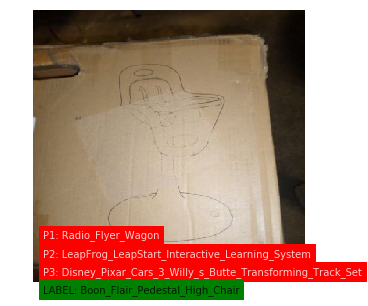

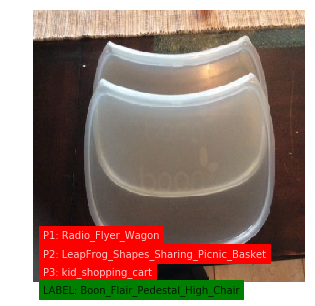

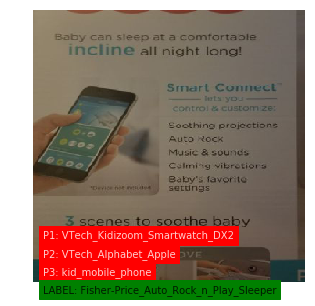

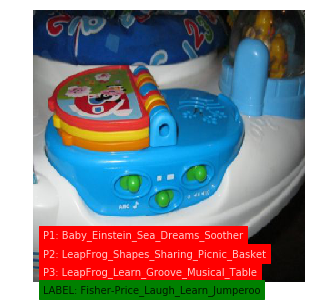

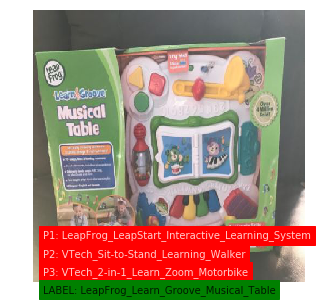

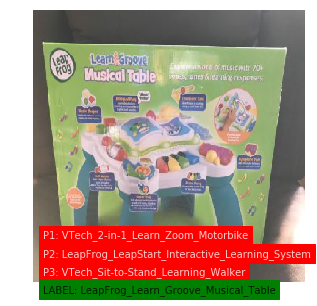

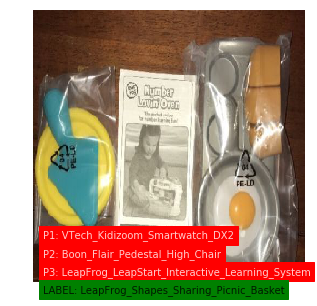

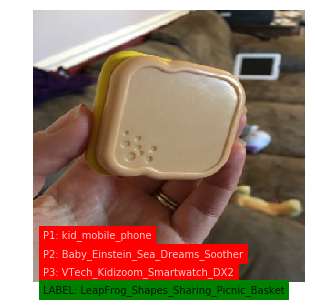

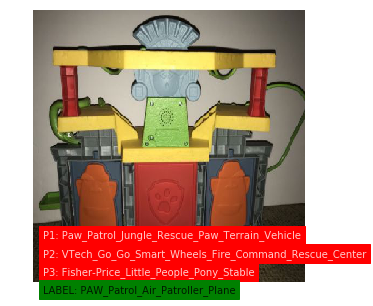

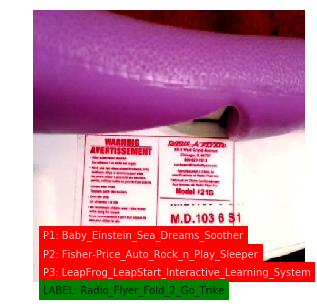

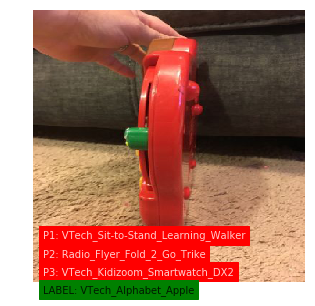

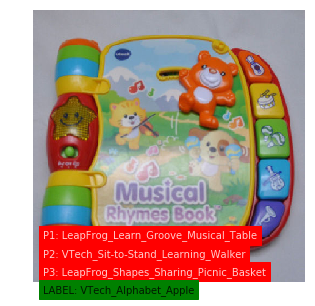

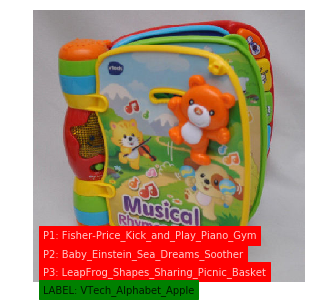

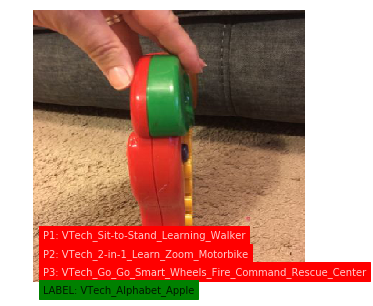

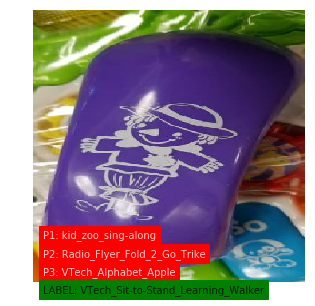

In [19]:
error_idx = top3_error_idx

for img_path, cat, pred1, pred2, pred3 in zip(list(compress(img_list, error_idx)),
                                              [class_list[int(b)] for b in true_classes[error_idx]],
                                              [class_list[int(b)] for b in pred1_classes[error_idx]],
                                              [class_list[int(b)] for b in pred2_classes[error_idx]],
                                              [class_list[int(b)] for b in pred3_classes[error_idx]]):
    fig, ax = plt.subplots(figsize=(5,5))
    img = image.load_img(join(valid_folder, img_path), target_size=(INPUT_SIZE,INPUT_SIZE))
    img = image.img_to_array(img)
    ax.imshow(img / 255.)
    ax.text(10, 250, 'P1: %s' % pred1, color='w', backgroundcolor='r', alpha=0.8)
    ax.text(10, 270, 'P2: %s' % pred2, color='w', backgroundcolor='r', alpha=0.8)
    ax.text(10, 290, 'P3: %s' % pred3, color='w', backgroundcolor='r', alpha=0.8)
    ax.text(10, 310, 'LABEL: %s' % cat, color='k', backgroundcolor='g', alpha=0.8)
    ax.axis('off')
    plt.show()       

## 7. Setup data to flow from directory with real-time augmentation

In [20]:
train_datagen = ImageDataGenerator(rescale=1. / 255,
                                   rotation_range=45,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.25,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(directory=train_folder,
                                                    target_size=(INPUT_SIZE,INPUT_SIZE),
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='categorical')

valid_datagen = ImageDataGenerator(rescale=1. / 255)
valid_generator = valid_datagen.flow_from_directory(directory=valid_folder,
                                                    target_size=(INPUT_SIZE,INPUT_SIZE),
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='categorical',
                                                    shuffle=False)

Found 1725 images belonging to 33 classes.
Found 418 images belonging to 33 classes.


## 8. Fine-tune 'base + top models'

In [21]:
#for i, layer in enumerate(model.layers):
#    print ('Layer #: {}, Name: {}'.format(i, layer.name))

for layer in model.layers[:126]:
    layer.trainable = False
for layer in model.layers[126:]:
    layer.trainable = True
    
# compile the model with a SGD/momentum optimizer
# and a very slow learning rate.
model.compile(optimizer = SGD(lr=1e-4, momentum=0.9),
              loss ='categorical_crossentropy',
              metrics = ['accuracy'])

# save weights of best training epoch: monitor either val_loss or val_acc
STAMP = "{}_complete_model".format(datetime.datetime.now().strftime("%Y-%m-%d"))
complete_model_weights_path = "models/{}.h5".format(STAMP)

# Authors suggest setting step_size = (2-8) x (training iterations in epoch)
step_size = 200
clr = CyclicLR(base_lr=8*1e-5,
               max_lr=4*1e-4,
               step_size=step_size,
               mode='exp_range',
               gamma=0.99994)

callbacks_list = [
    ModelCheckpoint(complete_model_weights_path, monitor='val_acc', verbose=1, save_best_only=True),
    EarlyStopping(monitor='val_loss', patience=5, verbose=1),
    clr
]

hist = model.fit_generator(train_generator,
                           steps_per_epoch=train_samples // BATCH_SIZE,
                           epochs=complete_model_epochs,
                           callbacks=callbacks_list,
                           validation_data=valid_generator,
                           validation_steps=valid_samples // BATCH_SIZE)

Epoch 1/50
107/107 [==============================] - 45s 418ms/step - loss: 0.7465 - acc: 0.7779 - val_loss: 0.3527 - val_acc: 0.9183

Epoch 00001: val_acc improved from -inf to 0.91827, saving model to models/2018-06-22_complete_model.h5
Epoch 2/50
107/107 [==============================] - 44s 413ms/step - loss: 0.7640 - acc: 0.7913 - val_loss: 0.3535 - val_acc: 0.9207

Epoch 00002: val_acc improved from 0.91827 to 0.92067, saving model to models/2018-06-22_complete_model.h5
Epoch 3/50
107/107 [==============================] - 44s 411ms/step - loss: 0.6684 - acc: 0.8076 - val_loss: 0.3577 - val_acc: 0.9159

Epoch 00003: val_acc did not improve
Epoch 4/50
107/107 [==============================] - 43s 406ms/step - loss: 0.6383 - acc: 0.8246 - val_loss: 0.3551 - val_acc: 0.9183

Epoch 00004: val_acc did not improve
Epoch 5/50
107/107 [==============================] - 43s 406ms/step - loss: 0.6625 - acc: 0.8073 - val_loss: 0.3586 - val_acc: 0.9159

Epoch 00005: val_acc did not improv

KeyboardInterrupt: 

## 9 (a). Retest with fine-tuned model (labeled validation images)

In [ ]:
generator = valid_generator
ypred = model.predict_generator(generator, verbose=1)

In [ ]:
img_list = generator.filenames
df = pd.DataFrame.from_dict(generator.class_indices, orient='index')
class_list = df.sort_values(by=0).index.tolist()

In [ ]:
true_classes = generator.classes
pred1_classes = np.argsort(ypred, axis=1)[:,-1] # or np.argmax(ypred, axis=1)
pred2_classes = np.argsort(ypred, axis=1)[:,-2]
pred3_classes = np.argsort(ypred, axis=1)[:,-3]
top1_error_idx = (true_classes != pred1_classes)
top3_error_idx = (true_classes != pred1_classes) & (true_classes != pred2_classes) & (true_classes != pred3_classes)

print ("Of {} images tested, top1 accuracy: {:.2f}% ({} wrong) and top3 accuracy: {:.2f}% ({} wrong)".format(
        len(img_list),
        (1-np.sum(top1_error_idx)/len(img_list))*100, np.sum(top1_error_idx),
        (1-np.sum(top3_error_idx)/len(img_list))*100, np.sum(top3_error_idx)))

In [ ]:
error_idx = top3_error_idx

for img_path, cat, pred1, pred2, pred3 in zip(list(compress(img_list, error_idx)),
                                              [class_list[int(b)] for b in true_classes[error_idx]],
                                              [class_list[int(b)] for b in pred1_classes[error_idx]],
                                              [class_list[int(b)] for b in pred2_classes[error_idx]],
                                              [class_list[int(b)] for b in pred3_classes[error_idx]]):
    fig, ax = plt.subplots(figsize=(5,5))
    img = image.load_img(join(valid_folder, img_path), target_size=(INPUT_SIZE,INPUT_SIZE))
    img = image.img_to_array(img)
    ax.imshow(img / 255.)
    ax.text(10, 250, 'P1: %s' % pred1, color='w', backgroundcolor='r', alpha=0.8)
    ax.text(10, 270, 'P2: %s' % pred2, color='w', backgroundcolor='r', alpha=0.8)
    ax.text(10, 290, 'P3: %s' % pred3, color='w', backgroundcolor='r', alpha=0.8)
    ax.text(10, 310, 'LABEL: %s' % cat, color='k', backgroundcolor='g', alpha=0.8)
    ax.axis('off')
    plt.show()       

## 9 (b). Test with unlabeled test images

In [ ]:
test_imgs = [f for f in listdir(test_folder) if isfile(join(test_folder, f))]
x_test = np.zeros((len(test_imgs), INPUT_SIZE, INPUT_SIZE, 3), dtype='float32')

for i, img_file in tqdm_notebook(enumerate(test_imgs)):
    img = image.load_img(join(test_folder, img_file), target_size=(INPUT_SIZE,INPUT_SIZE))
    img = image.img_to_array(img)
    x = preprocess_input(np.expand_dims(img.copy(), axis=0))
    x_test[i] = x
print('Test Images shape: {} size: {:,}'.format(x_test.shape, x_test.size))

generator = valid_generator
ypred = model.predict(x_test, batch_size=BATCH_SIZE, verbose=1)

In [ ]:
img_list = test_imgs
df = pd.DataFrame.from_dict(generator.class_indices, orient='index')
class_list = df.sort_values(by=0).index.tolist()

In [ ]:
pred1_classes = np.argsort(ypred, axis=1)[:,-1] # or np.argmax(ypred, axis=1)
pred2_classes = np.argsort(ypred, axis=1)[:,-2]
pred3_classes = np.argsort(ypred, axis=1)[:,-3]

In [ ]:
for img_path, pred1, pred2, pred3 in zip(img_list,
                                         [class_list[int(b)] for b in pred1_classes],
                                         [class_list[int(b)] for b in pred2_classes],
                                         [class_list[int(b)] for b in pred3_classes]):
    fig, ax = plt.subplots(figsize=(5,5))
    img = image.load_img(join(test_folder, img_path), target_size=(INPUT_SIZE,INPUT_SIZE))
    img = image.img_to_array(img)
    ax.imshow(img / 255.)
    ax.text(10, 250, 'P1: %s' % pred1, color='w', backgroundcolor='r', alpha=0.8)
    ax.text(10, 270, 'P2: %s' % pred2, color='w', backgroundcolor='r', alpha=0.8)
    ax.text(10, 290, 'P3: %s' % pred3, color='w', backgroundcolor='r', alpha=0.8)
    ax.axis('off')
    plt.show()       